In [4]:
from dataloader import DAVIS_Seq2, normalize_image, BallDataset, Balltest
from model import Model
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import PIL.Image as Image
import numpy as np
from preprocess_utensils import get_gray_image, get_boundary_iou
import json
from loss import order_loss, chamer_distance_loss
import random

In [5]:
!nvidia-smi

Fri Mar  8 12:15:46 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.14              Driver Version: 550.54.14      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-PCIE-40GB          On  |   00000000:37:00.0 Off |                    0 |
| N/A   54C    P0            137W /  250W |   25040MiB /  40960MiB |     50%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [6]:
data_set = BallDataset()
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_one_video=True)
# test_set = Balltest("ellipse/uniform_samples_80.json")
test_set = Balltest()

batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [7]:
pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx = next(iter(data_loader))
pre_idx, curr_idx

(tensor([6]), tensor([7]))

In [8]:
pre_frame.shape

torch.Size([1, 3, 224, 224])

Text(0.5, 1.0, 'Curr Frame')

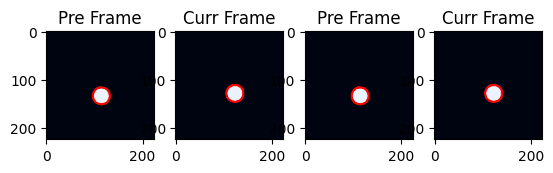

In [9]:
index = 0
plt.subplot(1, 4, 1)
plt.imshow(normalize_image(pre_frame[index].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 2)
plt.imshow(normalize_image(curr_frame[index].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')
plt.subplot(1, 4, 3)
plt.imshow(normalize_image(test_set[pre_idx][0].permute(1, 2, 0)))
plt.plot(pre_boundary[index][:, 0], pre_boundary[index][:, 1], 'r')
plt.title('Pre Frame')
plt.subplot(1, 4, 4)
plt.imshow(normalize_image(test_set[curr_idx][0].permute(1, 2, 0)))
plt.plot(curr_boundary[index][:, 0], curr_boundary[index][:, 1], 'r')
plt.title('Curr Frame')


In [10]:
model = Model()

/zhome/32/f/202284/CV/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [11]:
torch.cuda.empty_cache()

In [12]:
model = model.cuda()
output = model(pre_frame.to("cuda"), curr_frame.to("cuda"), pre_boundary.to("cuda")).cpu()
predic_boundary = output + pre_boundary
chamer_distance_loss(predic_boundary, curr_boundary.float())

tensor(36939.5742, grad_fn=<DivBackward0>)

In [13]:
model = Model().to('cuda')
model_name = "uniform_model"
data_set = BallDataset()
# data_set = BallDataset("ellipse/uniform_samples_80.json")
# data_set = DAVIS_Seq2(is_uniform=True, is_one_video=True)
# loss_name = "chamer_distance_loss"
loss_name = "order_loss"
if loss_name == "chamer_distance_loss":
    loss_func = chamer_distance_loss
else:
    loss_func = order_loss
batch_size = 1
data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=True, num_workers=4)

In [14]:
torch.cuda.memory_allocated() / 1024 / 1024 / 1024

0.2437748908996582

In [15]:
dict_loss = {}
pred_dict: dict[int, torch.Tensor] = {}
possibility = 0
poss_dict = {}

num_epochs = 1000
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-2)
gradient_clip = 2
min_loss = 1e10
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)
def lr_lambda(epoch):
    if epoch < 5:
        return 1
    elif epoch < 40:
        return 0.1
    else:
        return 0.01
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)
for e in range(num_epochs):
    model.train()
    mean_loss = 0
    poss_dict[e] = possibility
    # for pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in tqdm(data_loader, position=0, leave=True):
    for pre_frame, curr_frame, pre_boundary, curr_boundary, pre_idx, curr_idx in data_loader:
        pre_frame, curr_frame, pre_boundary, curr_boundary = (
            pre_frame.to("cuda"),
            curr_frame.to("cuda"),
            pre_boundary.to("cuda"),
            curr_boundary.to("cuda"),
        )
        pre_idx = pre_idx.item()
        curr_idx = curr_idx.item()
        if random.uniform(0, 100) < possibility:
            pre_boundary = pred_dict[pre_idx].to("cuda").detach()
        optimizer.zero_grad()
        output = model(pre_frame, curr_frame, pre_boundary)
        predic_boundary = output + pre_boundary
        pred_dict[curr_idx] = predic_boundary.int().clamp(0, 223)
        loss = loss_func(predic_boundary, curr_boundary.float())
        mean_loss += loss.item()
        nn.utils.clip_grad_norm_(model.parameters(), gradient_clip)
        loss.backward()
        optimizer.step()
        if loss.item() < min_loss:
            min_loss = loss.item()
            torch.save(model.state_dict(), f"./models/{model_name}_{loss_name}.pth")
    mean_loss /= len(data_loader)
    # tqdm.write(f"Epoch {e + 1}, Loss: {mean_loss}, Poss: {possibility}", end="")
    print(f"Epoch {e + 1}, Loss: {mean_loss:.2f}, Poss: {possibility}")
    dict_loss[e] = mean_loss
    if possibility < 50:
        possibility += 5
    # scheduler.step()

Epoch 1, Loss: 347.83, Poss: 0
Epoch 2, Loss: 239.34, Poss: 5
Epoch 3, Loss: 232.35, Poss: 10
Epoch 4, Loss: 193.91, Poss: 15
Epoch 5, Loss: 196.05, Poss: 20
Epoch 6, Loss: 205.42, Poss: 25
Epoch 7, Loss: 196.70, Poss: 30
Epoch 8, Loss: 174.07, Poss: 35
Epoch 9, Loss: 213.33, Poss: 40
Epoch 10, Loss: 218.73, Poss: 45
Epoch 11, Loss: 178.02, Poss: 50
Epoch 12, Loss: 186.37, Poss: 55
Epoch 13, Loss: 185.81, Poss: 60
Epoch 14, Loss: 171.42, Poss: 65


Epoch 15, Loss: 156.99, Poss: 70
Epoch 16, Loss: 181.40, Poss: 75
Epoch 17, Loss: 214.33, Poss: 80
Epoch 18, Loss: 189.52, Poss: 85
Epoch 19, Loss: 181.34, Poss: 90
Epoch 20, Loss: 197.56, Poss: 90
Epoch 21, Loss: 195.05, Poss: 90
Epoch 22, Loss: 189.39, Poss: 90
Epoch 23, Loss: 176.64, Poss: 90
Epoch 24, Loss: 196.16, Poss: 90
Epoch 25, Loss: 202.99, Poss: 90
Epoch 26, Loss: 176.95, Poss: 90
Epoch 27, Loss: 182.89, Poss: 90
Epoch 28, Loss: 183.62, Poss: 90
Epoch 29, Loss: 191.65, Poss: 90
Epoch 30, Loss: 176.85, Poss: 90
Epoch 31, Loss: 163.89, Poss: 90
Epoch 32, Loss: 164.45, Poss: 90
Epoch 33, Loss: 152.47, Poss: 90
Epoch 34, Loss: 162.96, Poss: 90
Epoch 35, Loss: 167.60, Poss: 90
Epoch 36, Loss: 195.65, Poss: 90
Epoch 37, Loss: 187.03, Poss: 90
Epoch 38, Loss: 185.09, Poss: 90
Epoch 39, Loss: 179.34, Poss: 90
Epoch 40, Loss: 141.24, Poss: 90
Epoch 41, Loss: 145.85, Poss: 90
Epoch 42, Loss: 146.14, Poss: 90
Epoch 43, Loss: 147.33, Poss: 90
Epoch 44, Loss: 159.25, Poss: 90
Epoch 45, 

In [18]:
pred_dict.keys()

dict_keys([0, 10, 7, 4, 1, 9, 11, 3, 6, 5, 2, 8])

In [40]:
# save loss
with open(f"./log/{model_name}_{loss_name}.json", "w") as f:
    json.dump(dict_loss, f)

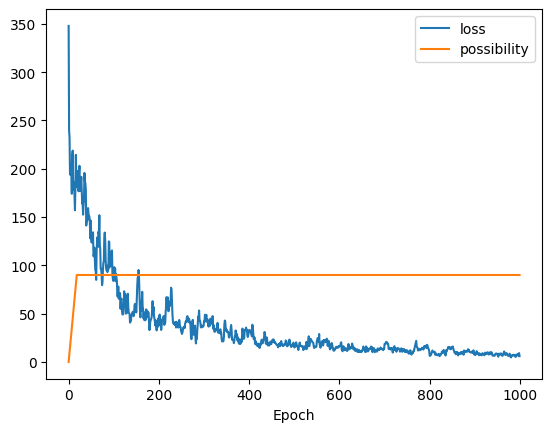

In [16]:
# plot the loss
plt.plot(list(dict_loss.keys()), list(dict_loss.values()), label="loss")
plt.plot(list(poss_dict.keys()), list(poss_dict.values()), label="possibility")
plt.xlabel("Epoch")
# plt.ylabel("Loss")
plt.legend()

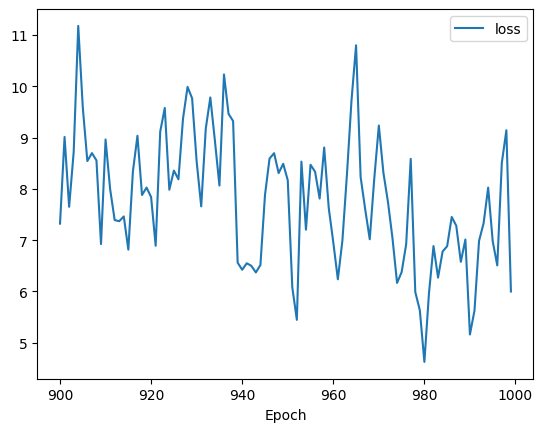

In [21]:
# plot the loss
plt.plot(list(dict_loss.keys())[-100:], list(dict_loss.values())[-100:], label="loss")
# plt.plot(list(poss_dict.keys())[-100:], list(poss_dict.values())[-100:], label="possibility")
plt.xlabel("Epoch")
# plt.ylabel("Loss")
plt.legend()

In [53]:
model = Model()
model_name = "uniform_model"
# model_name = "simplify_model"
# loss_name = "order_loss"
loss_name = "chamer_distance_loss"
model.load_state_dict(torch.load(f"./models/{model_name}_{loss_name}.pth"))
model = model.to("cuda")

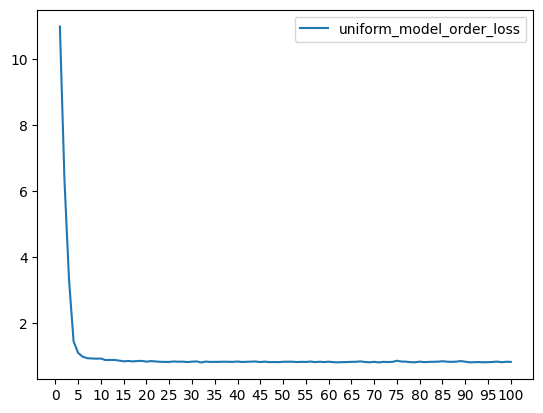

In [42]:
# load the loss
with open(f"./log/{model_name}_{loss_name}.json", "r") as f:
    dict_loss = json.load(f)
# plot the loss
plt.plot(np.array(list(dict_loss.keys())).astype(int) + 1, list(dict_loss.values()), label=f"{model_name}_{loss_name}")
# plt.legend(loc="lower right")
plt.legend()
# set the xticks
plt.xticks(np.arange(0, 101, 5))
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 24.57it/s]


0.38431001936419307

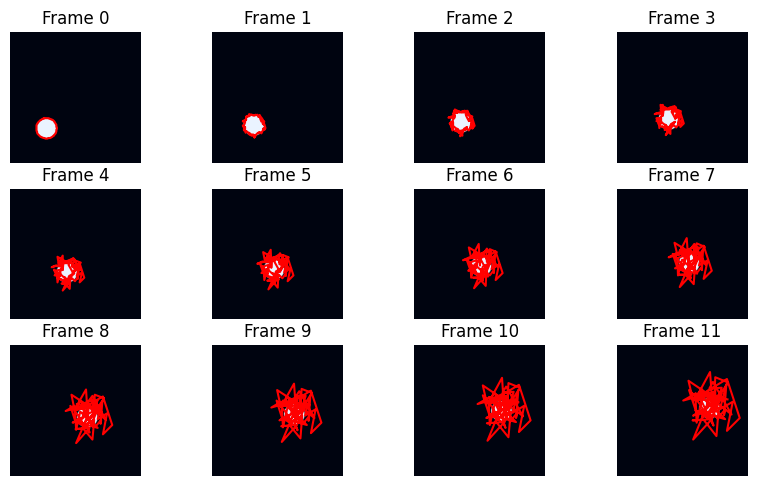

In [19]:
def test_model_one_video(model, test_dataset: torch.utils.data.Dataset, device="cuda"):
    pre_img, pre_sgm, pre_boundary = test_dataset[0]
    plt.figure(figsize=(10, 20))
    plt.subplot(10, 4, 1)
    plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
    plt.plot(pre_boundary[:, 0], pre_boundary[:, 1], 'r')
    plt.axis('off')
    plt.title('Frame 0')
    pre_boundary = pre_boundary.to(device)
    total_iou = 0
    model.eval()
    interval = 1
    for i in tqdm(range(1, len(test_dataset))):
        img, sgm, boundary = test_dataset[i]
        # print(pre_img.shape, img.shape, pre_boundary.shape)
        with torch.no_grad():
            boundary_offset = model(
                pre_img.unsqueeze(0).to(device),
                img.unsqueeze(0).to(device),
                pre_boundary.unsqueeze(0).to(device),
            )
            # pre_boundary[:, 0] += 9
            # print(boundary_offset)
            pre_boundary = pre_boundary + boundary_offset.squeeze(0)
            pre_boundary = pre_boundary.int()
            pre_boundary = torch.clamp(pre_boundary, 0, 223)
            # print(pre_boundary.cpu() - boundary)
            # pre_boundary = boundary.squeeze(0).to(device)
            pre_img = img
            if i % interval == 0:
                plt.subplot(10, 4, i // interval + 1)
                # plt.subplot(4, 4, i // interval)
                plt.imshow(normalize_image(pre_img.permute(1, 2, 0)))
                # index = 10
                # plt.scatter(pre_boundary.cpu().numpy()[:, 0][index], pre_boundary.cpu().numpy()[:, 1][index], )
                plt.plot(pre_boundary.cpu().numpy()[:, 0], pre_boundary.cpu().numpy()[:, 1], "r")
                plt.axis('off')
                plt.title(f'Frame {i}')
        total_iou += get_boundary_iou(sgm, pre_boundary.cpu().numpy())
    return total_iou / (len(test_dataset) - 1)
# if model_name == "uniform_model":
#     test_dataset = DAVIS_test("bear", is_uniform=True)
# else:
#     test_dataset = DAVIS_test("bear", is_uniform=False)
test_dataset = Balltest()
# test_dataset = Balltest("ellipse/uniform_samples_80.json")
test_model_one_video(model, test_dataset)